In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("final.csv")

In [3]:
df = df.drop(columns=['Unnamed: 0'])

In [4]:
vf_columns = [f'VF{i}' for i in range(61)]
df['VF_mean'] = df[vf_columns].mean(axis=1)
df['VF_median'] = df[vf_columns].median(axis=1)
df['VF_std'] = df[vf_columns].std(axis=1)
print(df[['Category of Glaucoma', 'VF_mean', 'VF_median', 'VF_std']].head())

  Category of Glaucoma    VF_mean  VF_median    VF_std
0                  OAG  19.163934       20.0  5.119181
1                  OAG  20.327869       21.0  6.828180
2                  OAG  19.327869       20.0  6.675131
3                  OAG  22.852459       23.0  5.029367
4                  OAG  22.540984       22.0  5.068115


In [5]:

subject_summary = df.groupby('SUBJECT NUMBER').agg(
    
    Age=('AGE', 'first'),
    Gender=('GENDER', 'first'),
    
    Total_Visits=('Visit Number', 'count'),
    
    Avg_Mean_RNFL=('Mean', 'mean'),
    Std_Mean_RNFL=('Mean', 'std'),
    
    Avg_VF_Mean=('VF_mean', 'mean'),
    
    Diagnosis=('Category of Glaucoma', 'first')
).reset_index()

print(subject_summary.head())

   SUBJECT NUMBER  Age Gender  Total_Visits  Avg_Mean_RNFL  Std_Mean_RNFL  \
0               1   46      F             7     101.571429       10.69045   
1               2   57      M             3      62.000000        0.00000   
2               3   41      M             7      89.000000        0.00000   
3               4   58      M             4     103.000000        0.00000   
4               5   59      F             6      95.000000        0.00000   

   Avg_VF_Mean Diagnosis  
0    21.477752       OAG  
1     8.737705       OAG  
2    21.892272       ACG  
3    19.905738       OAG  
4    19.489071       OAG  


In [6]:
subject_summary

,SUBJECT NUMBER,Age,Gender,Total_Visits,Avg_Mean_RNFL,Std_Mean_RNFL,Avg_VF_Mean,Diagnosis
0,1,46,F,7,101.571429,10.690450,21.477752,OAG
1,2,57,M,3,62.000000,0.000000,8.737705,OAG
2,3,41,M,7,89.000000,0.000000,21.892272,ACG
3,4,58,M,4,103.000000,0.000000,19.905738,OAG
4,5,59,F,6,95.000000,0.000000,19.489071,OAG
...,...,...,...,...,...,...,...,...
139,140,58,F,18,54.000000,5.144958,15.959927,OAG
140,141,18,F,13,106.538462,7.264243,24.889029,OAG
141,142,34,F,12,71.500000,5.744563,12.909836,OAG
142,143,51,F,8,102.500000,6.948792,25.737705,OAG


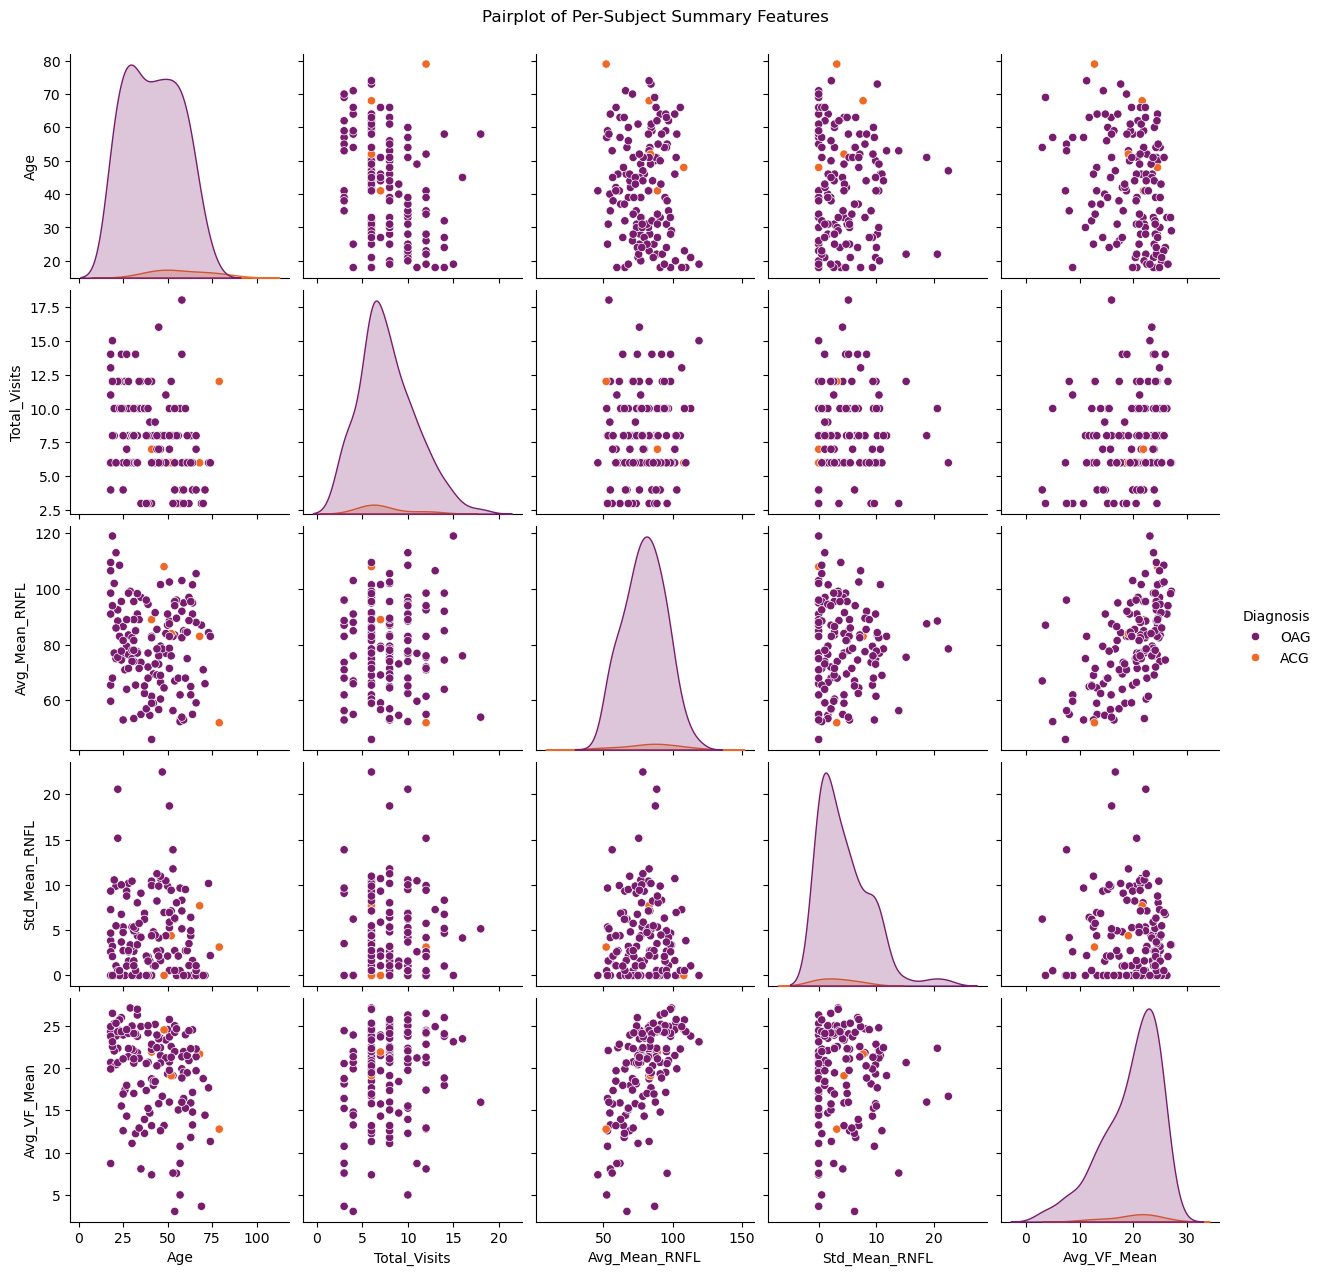

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

features_to_plot_summary = [
    'Age', 
    'Total_Visits', 
    'Avg_Mean_RNFL', 
    'Std_Mean_RNFL', 
    'Avg_VF_Mean', 
    'Diagnosis'
]

sns.pairplot(
    subject_summary[features_to_plot_summary], 
    hue='Diagnosis', 
    palette='inferno'
)

plt.suptitle('Pairplot of Per-Subject Summary Features', y=1.02)
plt.savefig("plot.jpg")


Class distribution:
Category of Glaucoma
OAG    1078
ACG      37
Name: count, dtype: int64


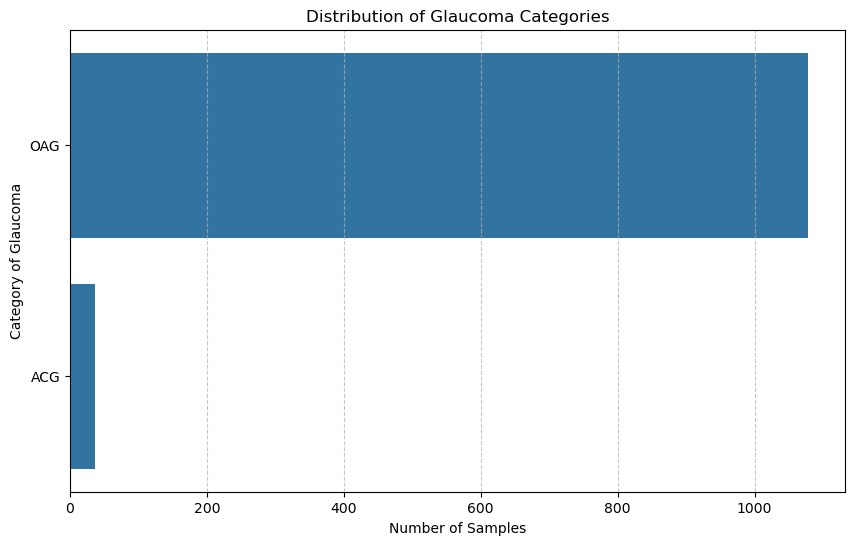

In [8]:

plt.figure(figsize=(10, 6))
sns.countplot(y=df['Category of Glaucoma'])
plt.title('Distribution of Glaucoma Categories')
plt.xlabel('Number of Samples')
plt.ylabel('Category of Glaucoma')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('class_distribution.png')

# Print the exact counts
print("Class distribution:")
print(df['Category of Glaucoma'].value_counts())

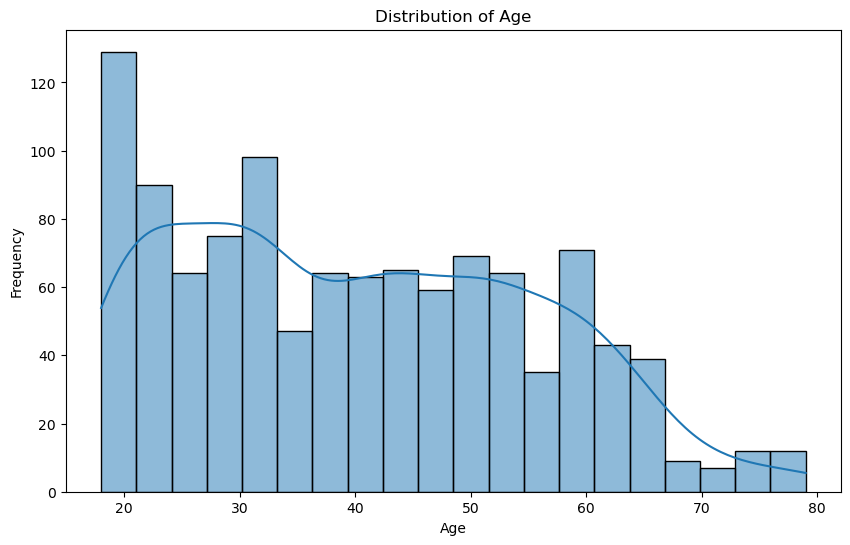

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['AGE'].dropna(), bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('age_distribution.png')

Text(0, 0.5, 'Count')

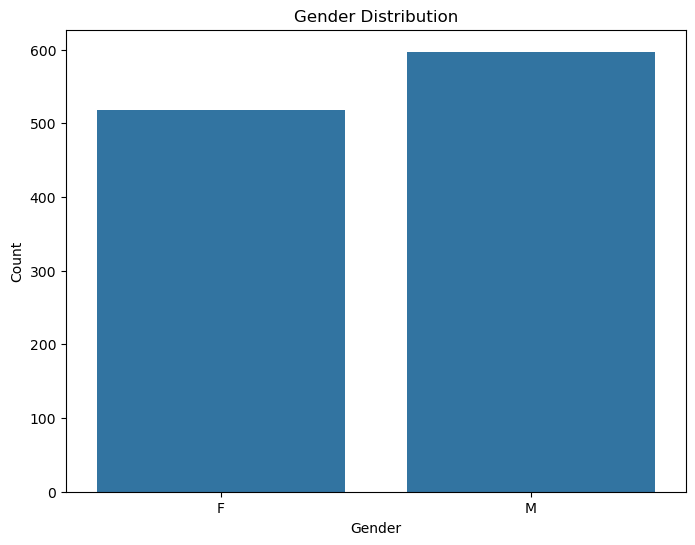

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x='GENDER', data=df.dropna(subset=['GENDER']))
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

Text(0, 0.5, 'Age')

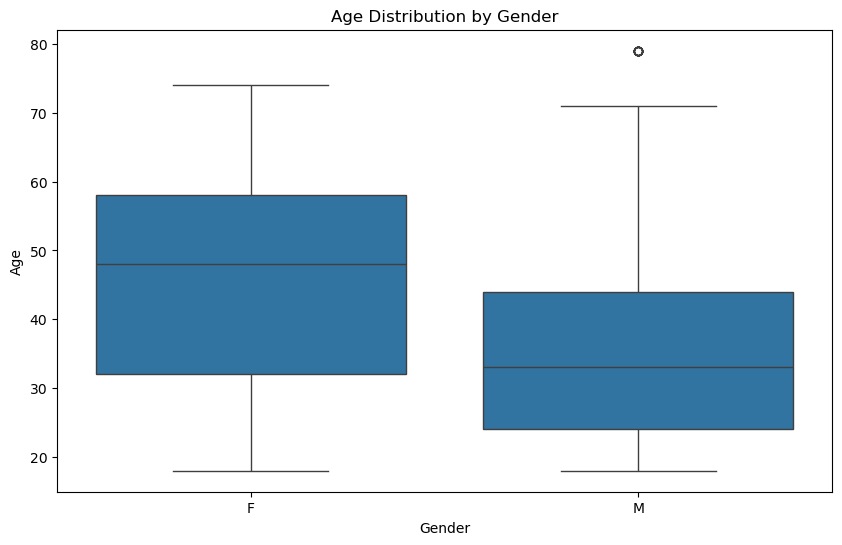

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='GENDER', y='AGE', data=df.dropna(subset=['GENDER', 'AGE']))
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')

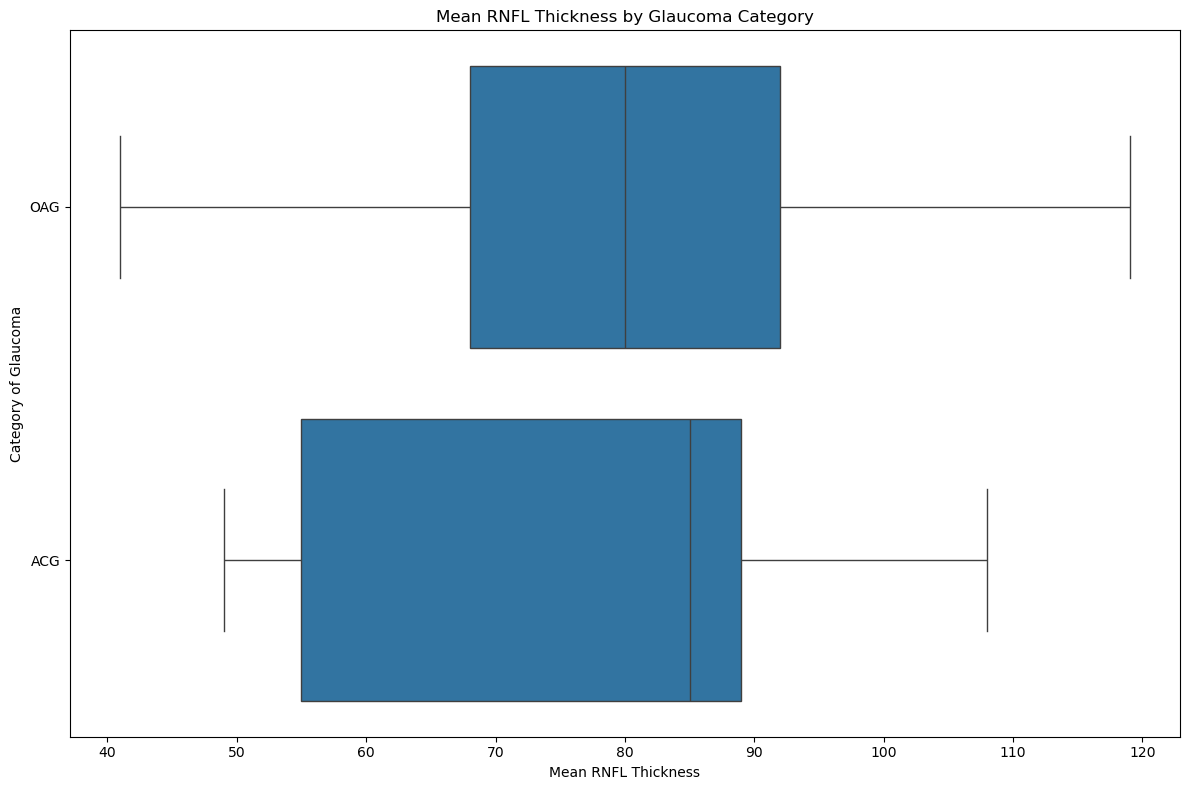

In [12]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Mean', y='Category of Glaucoma', data=df.dropna(subset=['Mean', 'Category of Glaucoma']), order = df.groupby('Category of Glaucoma')['Mean'].mean().sort_values(ascending=False).index)
plt.title('Mean RNFL Thickness by Glaucoma Category')
plt.xlabel('Mean RNFL Thickness')
plt.ylabel('Category of Glaucoma')
plt.tight_layout()

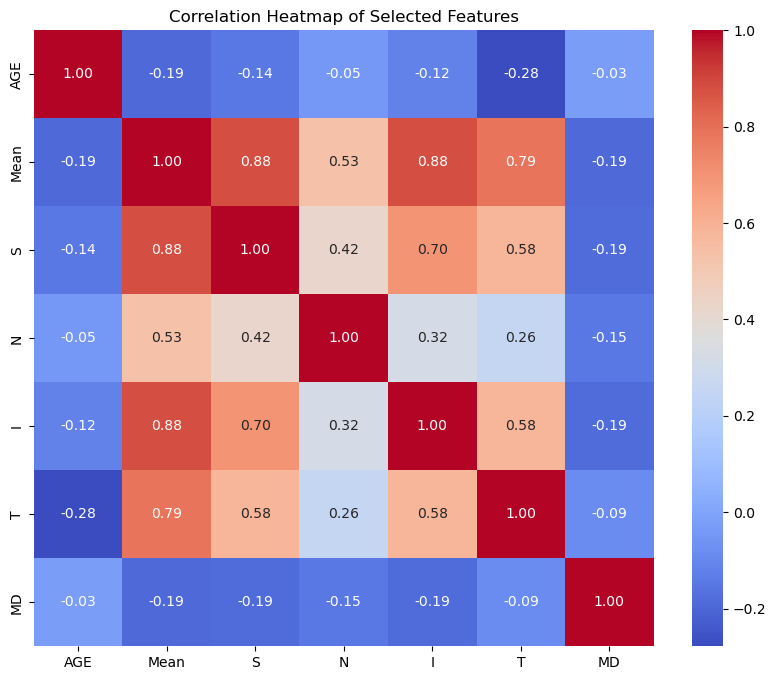

In [13]:
correlation_df = df[['AGE', 'Mean', 'S', 'N', 'I', 'T', 'MD']].copy()
correlation_df.dropna(inplace=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Selected Features')
plt.savefig('correlation_heatmap.png')

# BaseLINE randomforest 

In [14]:
import io
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
df = pd.read_csv("final.csv")


VF_POINT_DROP_DB = 3
VF_POINT_MIN_COUNT = 3
KEY_SUBJECT = "SUBJECT NUMBER"
KEY_LATERAL = "Laterality"
time_col = "Visit Number"

vf_cols = [c for c in df.columns if c.startswith("VF")]
df = df.sort_values([KEY_SUBJECT, KEY_LATERAL, time_col]).reset_index(drop=True)
df[vf_cols] = df[vf_cols].astype(float)

baseline_vf = df.groupby([KEY_SUBJECT, KEY_LATERAL])[vf_cols].first()
df = df.merge(baseline_vf.add_prefix("baseline_"), on=[KEY_SUBJECT, KEY_LATERAL], how="left")

for col in vf_cols:
    df[f"prev_{col}"] = df.groupby([KEY_SUBJECT, KEY_LATERAL])[col].shift(1)

baseline_worsened = []
for col in vf_cols:
    worsened = (df[col] - df[f"baseline_{col}"] <= -VF_POINT_DROP_DB).astype(int)
    baseline_worsened.append(worsened)
df["event_baseline"] = (np.vstack(baseline_worsened).T.sum(axis=1) >= VF_POINT_MIN_COUNT).astype(int)

def confirm_progression(group, colname):
    group = group.sort_values(time_col)
    return group[colname] & group[colname].shift(1).fillna(0).astype(bool)

df["progression_baseline"] = df.groupby([KEY_SUBJECT, KEY_LATERAL], group_keys=False).apply(confirm_progression, colname="event_baseline")
df["Clinical_Status_Baseline"] = df.groupby([KEY_SUBJECT, KEY_LATERAL])["progression_baseline"].cummax()



In [15]:
print("\n--- Training Machine Learning Model ---")
features = df[vf_cols]
target = df["Clinical_Status_Baseline"]
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)


model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)


--- Training Machine Learning Model ---


RandomForestClassifier(class_weight='balanced', random_state=42)

In [16]:
print("\n--- Model Performance on Unseen Test Data ---")
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


--- Model Performance on Unseen Test Data ---
Accuracy: 0.52

Confusion Matrix:
[[73 45]
 [61 44]]

Classification Report:
              precision    recall  f1-score   support

       False       0.54      0.62      0.58       118
        True       0.49      0.42      0.45       105

    accuracy                           0.52       223
   macro avg       0.52      0.52      0.52       223
weighted avg       0.52      0.52      0.52       223



In [17]:
new_patient_visit_data = X_test.iloc[[0]]
prediction_class = model.predict(new_patient_visit_data)[0]
prediction_proba = model.predict_proba(new_patient_visit_data)[0]


print("Sample Input Data (first 5 of 61 VF values):")
print(new_patient_visit_data.iloc[:, :5].to_string(header=False, index=False))
print("-" * 30)

if prediction_class == 1:
    print(f"Prediction: Glaucoma has Progressed (Class: {prediction_class})")
    print(f"Model Certainty: {prediction_proba[1]*100:.2f}%")
else:
    print(f"Prediction: Glaucoma has Not Progressed (Class: {prediction_class})")
    print(f"Model Certainty: {prediction_proba[0]*100:.2f}%")

Sample Input Data (first 5 of 61 VF values):
24.0 26.0 26.0 25.0 26.0
------------------------------
Prediction: Glaucoma has Progressed (Class: True)
Model Certainty: 54.00%


In [18]:

my_vf_values = [
    25, 26, 24, 27, 28, 29, 23, 28, 28, 25, 24, 25, 22, 21, 22, 26, 25, 28,
    27, 27, 27, -1, 22, 22, 23, 22, 22, 28, 25, 23, 29, 25, -1, 21, 20, 20,
    20, 21, 21, 22, 21, 22, 23, 26, 26, 22, 21, 22, 25, 27, 23, 21, 22, 21,
    21, 21, 23, 25, 22, 25, 22
]

# 2. Get the column names from the training data
vf_cols = [f'VF{i}' for i in range(61)]

# 3. Create a DataFrame for the model
input_data = pd.DataFrame([my_vf_values], columns=vf_cols)

# 4. Make the prediction
final_prediction = model.predict(input_data)[0]
final_probability = model.predict_proba(input_data)[0]

# 5. Print the result
if final_prediction == 1:
    print(f"Result: Glaucoma has Progressed. (Certainty: {final_probability[1]*100:.2f}%)")
else:
    print(f"Result: Glaucoma has Not Progressed. (Certainty: {final_probability[0]*100:.2f}%)")

Result: Glaucoma has Not Progressed. (Certainty: 73.00%)


# HYBRID xgboost


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# =============================================================================
# 1. DATA PREPARATION & MULTI-MODAL FEATURE ENGINEERING
# =============================================================================
print("--- Part 1: Loading Data and Engineering Multi-Modal 'Change from Baseline' Features ---")
try:
    df = pd.read_csv("final.csv")
    print("Successfully loaded final.csv")
except FileNotFoundError:
    print("Error: 'final.csv' not found.")
    df = pd.DataFrame()

if not df.empty:
    KEY_SUBJECT = "SUBJECT NUMBER"
    KEY_LATERAL = "Laterality"
    time_col = "Visit Number"

    # Define the different data modalities
    vf_cols = [c for c in df.columns if c.startswith('VF')]
    oct_cols = ['Mean', 'S', 'N', 'I', 'T']
    clinical_cols = ['AGE']
    all_feature_cols = vf_cols + oct_cols

    # Replace -1 with NaN
    df[all_feature_cols] = df[all_feature_cols].replace(-1, np.nan)

    # Impute original features with the mean
    for col in all_feature_cols:
        df[col] = df[col].fillna(df[col].mean())
    print("Missing values in source data have been imputed.")

    # Sort data chronologically
    df = df.sort_values([KEY_SUBJECT, KEY_LATERAL, time_col]).reset_index(drop=True)

    # --- Feature Engineering: Calculate Change from Baseline ---
    baseline_features = df.groupby([KEY_SUBJECT, KEY_LATERAL])[all_feature_cols].first()
    df_merged = df.merge(baseline_features.add_prefix("baseline_"), on=[KEY_SUBJECT, KEY_LATERAL], how="left")

    # Calculate the "delta" features
    delta_df_list = []
    for col in all_feature_cols:
        delta = df_merged[col] - df_merged[f"baseline_{col}"]
        delta_df_list.append(delta.rename(f"delta_{col}"))
    
    delta_df = pd.concat(delta_df_list, axis=1)

    # --- THE FINAL FIX: Impute the delta features themselves ---
    # Fill any NaN delta values with 0, assuming no measurable change
    delta_df.fillna(0, inplace=True)
    print("Engineered 'delta' features have been imputed.")

    # Combine all features into the final DataFrame
    df_final = pd.concat([df_merged, delta_df], axis=1)
    
    print(f"Feature engineering complete. Shape of final DataFrame: {df_final.shape}")

    # =============================================================================
    # 2. XGBOOST MODEL WITH MULTI-MODAL FEATURES
    # =============================================================================
    
    if df_final.empty:
        print("Error: DataFrame is still empty. The issue persists.")
    else:
        features_to_use = list(delta_df.columns) + clinical_cols
        features = df_final[features_to_use]
        target = df_final["Clinical_Status_Baseline"]

        print(f"\n--- Training XGBoost on Multi-Modal DELTA Features ---")

        X_train, X_test, y_train, y_test = train_test_split(
            features, target, test_size=0.2, random_state=42, stratify=target
        )

        model = XGBClassifier(random_state=42, eval_metric='logloss')
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        
        print(f"\n--- Model Performance ---")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred, zero_division=0))
        

--- Part 1: Loading Data and Engineering Multi-Modal 'Change from Baseline' Features ---
Successfully loaded final.csv
Missing values in source data have been imputed.
Engineered 'delta' features have been imputed.
Feature engineering complete. Shape of final DataFrame: (1115, 211)

--- Training XGBoost on Multi-Modal DELTA Features ---

--- Model Performance ---
Accuracy: 0.646
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.54      0.62       118
           1       0.60      0.76      0.67       105

    accuracy                           0.65       223
   macro avg       0.66      0.65      0.64       223
weighted avg       0.66      0.65      0.64       223



 # VF AND OCT BASELINE

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# =============================================================================
# 1. DATA PREPARATION - OCT + VF VALUES ONLY
# =============================================================================
print("--- Loading Data and Engineering 'Change from Baseline' Features (OCT + VF only) ---")
df = pd.read_csv("final.csv")

KEY_SUBJECT = "SUBJECT NUMBER"
KEY_LATERAL = "Laterality"
time_col = "Visit Number"

# --- Select only VF + OCT columns ---
vf_cols  = [c for c in df.columns if c.upper().startswith('VF')]
oct_cols = [c for c in df.columns if c.upper().startswith('OCT')]
feat_cols = vf_cols + oct_cols

# Replace -1 with NaN and fill missing with mean per column
df[feat_cols] = df[feat_cols].replace(-1, np.nan)
for col in feat_cols:
    df[col] = df[col].fillna(df[col].mean())

# Sort chronologically for baseline calculation
df = df.sort_values([KEY_SUBJECT, KEY_LATERAL, time_col]).reset_index(drop=True)

# --- Feature Engineering: Change from Baseline (OCT + VF only) ---
baseline_feat = df.groupby([KEY_SUBJECT, KEY_LATERAL])[feat_cols].first()
df_merged = df.merge(baseline_feat.add_prefix("baseline_"), on=[KEY_SUBJECT, KEY_LATERAL], how="left")

# Compute delta features
delta_df = pd.DataFrame()
for col in feat_cols:
    delta_df[f"delta_{col}"] = df_merged[col] - df_merged[f"baseline_{col}"]

delta_df.fillna(0, inplace=True)  # assume no change if NaN

# Final features (delta OCT + VF only)
features = delta_df

# =============================================================================
# 2. XGBOOST MODEL - DELTA FEATURES (OCT + VF only)
# =============================================================================
target = df_merged["Clinical_Status_Baseline"]  # or "Clinical_Status_Hybrid"

print(f"\n--- Training XGBoost on Delta OCT+VF Features ---")

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"\n--- Model Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

b

--- Loading Data and Engineering 'Change from Baseline' Features (OCT + VF only) ---

--- Training XGBoost on Delta OCT+VF Features ---

--- Model Performance ---
Accuracy: 0.646
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.50      0.60       118
           1       0.59      0.81      0.68       105

    accuracy                           0.65       223
   macro avg       0.67      0.65      0.64       223
weighted avg       0.67      0.65      0.64       223



# VF AND OCT HYBRID

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# =============================================================================
# 1. DATA PREPARATION - OCT + VF VALUES ONLY
# =============================================================================
print("--- Loading Data and Engineering 'Change from Baseline' Features (OCT + VF only) ---")
df = pd.read_csv("final.csv")

KEY_SUBJECT = "SUBJECT NUMBER"
KEY_LATERAL = "Laterality"
time_col = "Visit Number"

# --- Select only VF + OCT columns ---
vf_cols  = [c for c in df.columns if c.upper().startswith('VF')]
oct_cols = [c for c in df.columns if c.upper().startswith('OCT')]
feat_cols = vf_cols + oct_cols

# Replace -1 with NaN and fill missing with mean per column
df[feat_cols] = df[feat_cols].replace(-1, np.nan)
for col in feat_cols:
    df[col] = df[col].fillna(df[col].mean())

# Sort chronologically for baseline calculation
df = df.sort_values([KEY_SUBJECT, KEY_LATERAL, time_col]).reset_index(drop=True)

# --- Feature Engineering: Change from Baseline (OCT + VF only) ---
baseline_feat = df.groupby([KEY_SUBJECT, KEY_LATERAL])[feat_cols].first()
df_merged = df.merge(baseline_feat.add_prefix("baseline_"), on=[KEY_SUBJECT, KEY_LATERAL], how="left")

# Compute delta features
delta_df = pd.DataFrame()
for col in feat_cols:
    delta_df[f"delta_{col}"] = df_merged[col] - df_merged[f"baseline_{col}"]

delta_df.fillna(0, inplace=True)  # assume no change if NaN

# Final features (delta OCT + VF only)
features = delta_df

# =============================================================================
# 2. XGBOOST MODEL - DELTA FEATURES (OCT + VF only)
# =============================================================================
target = df_merged["Clinical_Status_Hybrid"]  # or "Clinical_Status_Hybrid"

print(f"\n--- Training XGBoost on Delta OCT+VF Features ---")

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"\n--- Model Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))




--- Loading Data and Engineering 'Change from Baseline' Features (OCT + VF only) ---

--- Training XGBoost on Delta OCT+VF Features ---

--- Model Performance ---
Accuracy: 0.668
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.54      0.62       113
           1       0.63      0.80      0.70       110

    accuracy                           0.67       223
   macro avg       0.68      0.67      0.66       223
weighted avg       0.68      0.67      0.66       223



# xgboost hybrid only vf Values

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# =============================================================================
# 1. DATA PREPARATION - VF VALUES ONLY
# =============================================================================
print("--- Loading Data and Engineering 'Change from Baseline' Features (VF only) ---")
df = pd.read_csv("final.csv")

KEY_SUBJECT = "SUBJECT NUMBER"
KEY_LATERAL = "Laterality"
time_col = "Visit Number"

# --- Only VF columns ---
vf_cols = [c for c in df.columns if c.startswith('VF')]

# Replace -1 with NaN and fill missing with mean
df[vf_cols] = df[vf_cols].replace(-1, np.nan)
for col in vf_cols:
    df[col] = df[col].fillna(df[col].mean())

# Sort chronologically
df = df.sort_values([KEY_SUBJECT, KEY_LATERAL, time_col]).reset_index(drop=True)

# --- Feature Engineering: Change from Baseline (VF only) ---
baseline_vf = df.groupby([KEY_SUBJECT, KEY_LATERAL])[vf_cols].first()
df_merged = df.merge(baseline_vf.add_prefix("baseline_"), on=[KEY_SUBJECT, KEY_LATERAL], how="left")

# Compute delta features
delta_df = pd.DataFrame()
for col in vf_cols:
    delta_df[f"delta_{col}"] = df_merged[col] - df_merged[f"baseline_{col}"]

delta_df.fillna(0, inplace=True)  # assume no change if NaN

# Final features (delta VF only)
features = delta_df

# =============================================================================
# 2. XGBOOST MODEL - VF DELTA FEATURES ONLY
# =============================================================================

target = df_merged["Clinical_Status_Hybrid"]  # or "Clinical_Status_Hybrid"

print(f"\n--- Training XGBoost on VF Delta Features Only ---")

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"\n--- Model Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# =============================================================================
# 3. Predict on a New Visit
# =============================================================================
# Example: new VF values at one visit (must be 60 values in same order as vf_cols)
# new_vf_values = [...]  # your 60 VF values here
# new_baseline_values = [...]  # the same patient's baseline 60 VF values
# new_delta = np.array(new_vf_values) - np.array(new_baseline_values)
# new_df = pd.DataFrame([new_delta], columns=[f"delta_{c}" for c in vf_cols])
# prediction = model.predict(new_df)
# print("Predicted Progression Status:", prediction[0])


--- Loading Data and Engineering 'Change from Baseline' Features (VF only) ---

--- Training XGBoost on VF Delta Features Only ---

--- Model Performance ---
Accuracy: 0.668
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.54      0.62       113
           1       0.63      0.80      0.70       110

    accuracy                           0.67       223
   macro avg       0.68      0.67      0.66       223
weighted avg       0.68      0.67      0.66       223



# different classifiers

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv("final.csv")
KEY_SUBJECT = "SUBJECT NUMBER"
KEY_LATERAL = "Laterality"
time_col = "Visit Number"
vf_cols = [c for c in df.columns if c.startswith("VF")]

# Replace -1 with NaN and fill missing
df[vf_cols] = df[vf_cols].replace(-1, np.nan)
for col in vf_cols:
    df[col] = df[col].fillna(df[col].mean())

# Sort data
df = df.sort_values([KEY_SUBJECT, KEY_LATERAL, time_col]).reset_index(drop=True)

# Compute delta features
baseline_vf = df.groupby([KEY_SUBJECT, KEY_LATERAL])[vf_cols].first()
df_merged = df.merge(baseline_vf.add_prefix("baseline_"), on=[KEY_SUBJECT, KEY_LATERAL], how="left")
delta_df = pd.DataFrame({f"delta_{col}": df_merged[col] - df_merged[f"baseline_{col}"] for col in vf_cols})
delta_df.fillna(0, inplace=True)

features = delta_df
target = df_merged["Clinical_Status_Baseline"]  # or "Clinical_Status_Hybrid"

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

# -----------------------------
# Models to compare
# -----------------------------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss'),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
}

# -----------------------------
# Train, predict and compare
# -----------------------------
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred, zero_division=0))

# Compare accuracies
print("\n=== Summary of Model Accuracies ===")
for name, acc in results.items():
    print(f"{name}: {acc:.3f}")




=== RandomForest ===
Accuracy: 0.664
              precision    recall  f1-score   support

           0       0.80      0.48      0.60       118
           1       0.60      0.87      0.71       105

    accuracy                           0.66       223
   macro avg       0.70      0.67      0.66       223
weighted avg       0.71      0.66      0.65       223


=== XGBoost ===
Accuracy: 0.646
              precision    recall  f1-score   support

           0       0.75      0.50      0.60       118
           1       0.59      0.81      0.68       105

    accuracy                           0.65       223
   macro avg       0.67      0.65      0.64       223
weighted avg       0.67      0.65      0.64       223


=== GradientBoosting ===
Accuracy: 0.655
              precision    recall  f1-score   support

           0       0.73      0.56      0.63       118
           1       0.61      0.76      0.68       105

    accuracy                           0.65       223
   macro avg   

# Hyperparameter tuning of all classifiers Baseline

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import randint, uniform

# -----------------------------
# 1. Load & prepare data
# -----------------------------
df = pd.read_csv("final.csv")
KEY_SUBJECT = "SUBJECT NUMBER"
KEY_LATERAL = "Laterality"
time_col = "Visit Number"
vf_cols = [c for c in df.columns if c.startswith("VF")]

# Replace -1 with NaN and fill missing
df[vf_cols] = df[vf_cols].replace(-1, np.nan)
for col in vf_cols:
    df[col] = df[col].fillna(df[col].mean())

df = df.sort_values([KEY_SUBJECT, KEY_LATERAL, time_col]).reset_index(drop=True)

# Compute delta features
baseline_vf = df.groupby([KEY_SUBJECT, KEY_LATERAL])[vf_cols].first()
df_merged = df.merge(baseline_vf.add_prefix("baseline_"), on=[KEY_SUBJECT, KEY_LATERAL], how="left")
delta_df = pd.DataFrame({f"delta_{col}": df_merged[col] - df_merged[f"baseline_{col}"] for col in vf_cols})
delta_df.fillna(0, inplace=True)

X = delta_df
y = df_merged["Clinical_Status_Baseline"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 2. Define models + hyperparameter grids
# -----------------------------
models_grids = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'),
        "params": {
            "n_estimators": randint(100, 500),
            "max_depth": randint(3, 15),
            "min_samples_split": randint(2, 10),
            "min_samples_leaf": randint(1, 5),
            "max_features": ['sqrt', 'log2', None]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
        "params": {
            "n_estimators": randint(100, 500),
            "max_depth": randint(3, 10),
            "learning_rate": uniform(0.01, 0.3),
            "subsample": uniform(0.6, 0.4),
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": randint(100, 500),
            "learning_rate": uniform(0.01, 0.3),
            "max_depth": randint(3, 10),
            "subsample": uniform(0.6, 0.4)
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        "params": {
            "C": uniform(0.01, 10),
            "penalty": ['l1', 'l2'],
            "solver": ['liblinear', 'saga']
        }
    }
}

# -----------------------------
# 3. Randomized search + evaluation
# -----------------------------
results = {}
for name, mg in models_grids.items():
    print(f"\n--- Tuning {name} ---")
    rs = RandomizedSearchCV(
        mg["model"],
        mg["params"],
        n_iter=20,           # number of random combinations to try
        cv=3,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    rs.fit(X_train, y_train)
    best_model = rs.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {
        "best_model": best_model,
        "accuracy": acc,
        "classification_report": classification_report(y_test, y_pred, zero_division=0)
    }
    print(f"Best parameters: {rs.best_params_}")
    print(f"Test Accuracy: {acc:.3f}")
    print(results[name]["classification_report"])

# -----------------------------
# 4. Summary
# -----------------------------
print("\n=== Model Comparison ===")
for name, res in results.items():
    print(f"{name}: Accuracy = {res['accuracy']:.3f}")




--- Tuning RandomForest ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 413}
Test Accuracy: 0.686
              precision    recall  f1-score   support

           0       0.88      0.47      0.62       118
           1       0.61      0.92      0.73       105

    accuracy                           0.69       223
   macro avg       0.74      0.70      0.68       223
weighted avg       0.75      0.69      0.67       223


--- Tuning XGBoost ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\chait\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:45:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'colsample_bytree': np.float64(0.7599443886861021), 'learning_rate': np.float64(0.023999698964084628), 'max_depth': 6, 'n_estimators': 370, 'subsample': np.float64(0.7824279936868144)}
Test Accuracy: 0.664
              precision    recall  f1-score   support

           0       0.78      0.51      0.62       118
           1       0.60      0.84      0.70       105

    accuracy                           0.66       223
   macro avg       0.69      0.67      0.66       223
weighted avg       0.70      0.66      0.66       223


--- Tuning GradientBoosting ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'learning_rate': np.float64(0.023999698964084628), 'max_depth': 6, 'n_estimators': 370, 'subsample': np.float64(0.7824279936868144)}
Test Accuracy: 0.686
              precision    recall  f1-score   support

           0       0.80      0.54      0.65       118
           1       0.62      0.85      0.72       105

    accuracy       

# hyperparameter tuning for HYBRID

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import randint, uniform

# -----------------------------
# 1. Load & prepare data
# -----------------------------
df = pd.read_csv("final.csv")
KEY_SUBJECT = "SUBJECT NUMBER"
KEY_LATERAL = "Laterality"
time_col = "Visit Number"
vf_cols = [c for c in df.columns if c.startswith("VF")]

# Replace -1 with NaN and fill missing
df[vf_cols] = df[vf_cols].replace(-1, np.nan)
for col in vf_cols:
    df[col] = df[col].fillna(df[col].mean())

df = df.sort_values([KEY_SUBJECT, KEY_LATERAL, time_col]).reset_index(drop=True)

# Compute delta features
baseline_vf = df.groupby([KEY_SUBJECT, KEY_LATERAL])[vf_cols].first()
df_merged = df.merge(baseline_vf.add_prefix("baseline_"), on=[KEY_SUBJECT, KEY_LATERAL], how="left")
delta_df = pd.DataFrame({f"delta_{col}": df_merged[col] - df_merged[f"baseline_{col}"] for col in vf_cols})
delta_df.fillna(0, inplace=True)

X = delta_df
y = df_merged["Clinical_Status_Hybrid"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 2. Define models + hyperparameter grids
# -----------------------------
models_grids = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'),
        "params": {
            "n_estimators": randint(100, 500),
            "max_depth": randint(3, 15),
            "min_samples_split": randint(2, 10),
            "min_samples_leaf": randint(1, 5),
            "max_features": ['sqrt', 'log2', None]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
        "params": {
            "n_estimators": randint(100, 500),
            "max_depth": randint(3, 10),
            "learning_rate": uniform(0.01, 0.3),
            "subsample": uniform(0.6, 0.4),
            "colsample_bytree": uniform(0.6, 0.4)
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": randint(100, 500),
            "learning_rate": uniform(0.01, 0.3),
            "max_depth": randint(3, 10),
            "subsample": uniform(0.6, 0.4)
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        "params": {
            "C": uniform(0.01, 10),
            "penalty": ['l1', 'l2'],
            "solver": ['liblinear', 'saga']
        }
    }
}

# -----------------------------
# 3. Randomized search + evaluation
# -----------------------------
results = {}
for name, mg in models_grids.items():
    print(f"\n--- Tuning {name} ---")
    rs = RandomizedSearchCV(
        mg["model"],
        mg["params"],
        n_iter=20,           # number of random combinations to try
        cv=3,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    rs.fit(X_train, y_train)
    best_model = rs.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {
        "best_model": best_model,
        "accuracy": acc,
        "classification_report": classification_report(y_test, y_pred, zero_division=0)
    }
    print(f"Best parameters: {rs.best_params_}")
    print(f"Test Accuracy: {acc:.3f}")
    print(results[name]["classification_report"])


print("\n=== Model Comparison ===")
for name, res in results.items():
    print(f"{name}: Accuracy = {res['accuracy']:.3f}")





--- Tuning RandomForest ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 291}
Test Accuracy: 0.717
              precision    recall  f1-score   support

           0       0.90      0.50      0.64       113
           1       0.65      0.95      0.77       110

    accuracy                           0.72       223
   macro avg       0.77      0.72      0.70       223
weighted avg       0.78      0.72      0.70       223


--- Tuning XGBoost ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\chait\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:46:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'colsample_bytree': np.float64(0.8446612641953124), 'learning_rate': np.float64(0.012119891565915222), 'max_depth': 3, 'n_estimators': 148, 'subsample': np.float64(0.8099098641033556)}
Test Accuracy: 0.731
              precision    recall  f1-score   support

           0       0.86      0.56      0.68       113
           1       0.67      0.91      0.77       110

    accuracy                           0.73       223
   macro avg       0.76      0.73      0.72       223
weighted avg       0.77      0.73      0.72       223


--- Tuning GradientBoosting ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'learning_rate': np.float64(0.1929989973347863), 'max_depth': 9, 'n_estimators': 134, 'subsample': np.float64(0.9637281608315128)}
Test Accuracy: 0.691
              precision    recall  f1-score   support

           0       0.78      0.54      0.64       113
           1       0.64      0.85      0.73       110

    accuracy         